<img src="./whats_cooking_img.png" width="500">

<center><h1>Kaggle Competition - "What's Cooking?"</h1></center>
<center><h2>CSCD 429 - Final Project</h2></center>
<center><h4>Andrew Combs, Eli Swanson, Richard Teller, Mike</h4></center>
<hr>

### Problem Overview

The point of this competition is to, given a list of ingredients for a recipe, predict the cuisine of the recipe.  Examples of cuisines are: italian, mexican, thai, japanese, spanish, etc.

- The training data is given in json format with the list of ingredients paired with the type of cuisine that the recipe is.

- The test data simply consists of the lists of ingredients for each recipe.

Thus we have a supervised, multi-class, classification problem.

### Data Analysis and Cleaning

Let's load in the data and see what we can discover.  Throughout this section we will be manipulating the training data and cleaning it.  Any steps we take that are successful in preparing the data we will also apply to the test set as well.

In [13]:
# Preliminaries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from wordcloud import WordCloud

COLOR = '#80aaff' # The color we will use to graph our data

In [14]:
train_data = pd.read_json('./Data/train.json')
test_data = pd.read_json('./Data/test.json')

train_data.head(10)

,cuisine,id,ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,22213,"[water, vegetable oil, wheat, salt]"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe..."
5,jamaican,6602,"[plain flour, sugar, butter, eggs, fresh ginge..."
6,spanish,42779,"[olive oil, salt, medium shrimp, pepper, garli..."
7,italian,3735,"[sugar, pistachio nuts, white almond bark, flo..."
8,mexican,16903,"[olive oil, purple onion, fresh pineapple, por..."
9,italian,12734,"[chopped tomatoes, fresh basil, garlic, extra-..."


In [15]:
print(train_data.shape)
print(test_data.shape)

(39774, 3)
(9944, 2)


So we see there are:
- 39774 training tuples
- 9944 test tuples

Let's see how many different cuisines there are.

In [16]:
from collections import Counter

cuisine_counts = Counter(train_data['cuisine'])
print("Number of unique cuisines: {}".format(len(cuisine_counts.keys())))

Number of unique cuisines: 20


<BarContainer object of 20 artists>

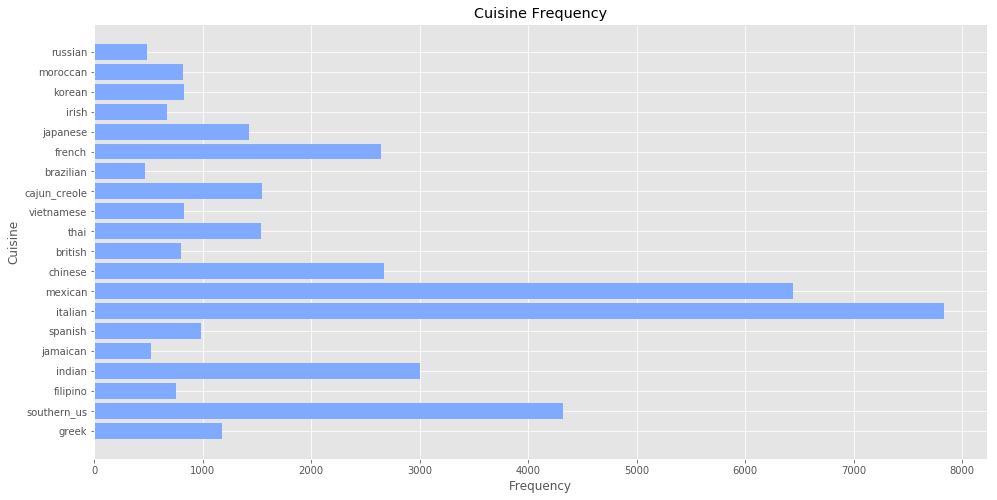

In [17]:
plt.figure(figsize=(16,8))
plt.xlabel('Frequency')
plt.ylabel('Cuisine')
plt.title('Cuisine Frequency')
plt.barh(list(cuisine_counts.keys()), list(cuisine_counts.values()), color=COLOR)

Currently the ingredients are a list object.  Let's transform each ingredient list into a string where each ingredient is separated by a comma.

We will also determine the number of ingredients for each recipe and tack both of these onto the dataframe as columns.

In [18]:
train_data['ingredients_text'] = train_data['ingredients'].apply(lambda x: ', '.join(x))
train_data['num_ingredients'] = train_data['ingredients'].apply(lambda x: len(x))

# Perform the same action to the test data
test_data['ingredients_text'] = test_data['ingredients'].apply(lambda x: ', '.join(x))
test_data['num_ingredients'] = test_data['ingredients'].apply(lambda x: len(x))

train_data.head(10)

,cuisine,id,ingredients,ingredients_text,num_ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes...","romaine lettuce, black olives, grape tomatoes,...",9
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g...","plain flour, ground pepper, salt, tomatoes, gr...",11
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g...","eggs, pepper, salt, mayonaise, cooking oil, gr...",12
3,indian,22213,"[water, vegetable oil, wheat, salt]","water, vegetable oil, wheat, salt",4
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe...","black pepper, shallots, cornflour, cayenne pep...",20
5,jamaican,6602,"[plain flour, sugar, butter, eggs, fresh ginge...","plain flour, sugar, butter, eggs, fresh ginger...",12
6,spanish,42779,"[olive oil, salt, medium shrimp, pepper, garli...","olive oil, salt, medium shrimp, pepper, garlic...",13
7,italian,3735,"[sugar, pistachio nuts, white almond bark, flo...","sugar, pistachio nuts, white almond bark, flou...",10
8,mexican,16903,"[olive oil, purple onion, fresh pineapple, por...","olive oil, purple onion, fresh pineapple, pork...",13
9,italian,12734,"[chopped tomatoes, fresh basil, garlic, extra-...","chopped tomatoes, fresh basil, garlic, extra-v...",6


## Ingredient Analysis

<BarContainer object of 43 artists>

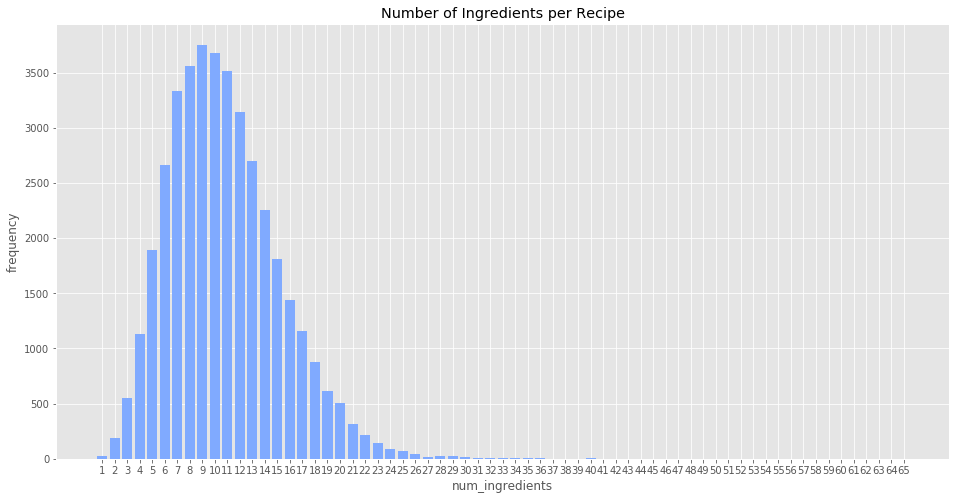

In [19]:
num_ingredients_counts = Counter(train_data['num_ingredients'])

plt.figure(figsize=(16,8))
plt.xlabel('num_ingredients')
plt.ylabel('frequency')
plt.title('Number of Ingredients per Recipe')
plt.xticks(range(min(num_ingredients_counts.keys()), max(num_ingredients_counts.keys())+1))
plt.bar(list(num_ingredients_counts.keys()), list(num_ingredients_counts.values()), color=COLOR)

In [20]:
print("Max ingredients in a recipe: {}".format(max(num_ingredients_counts.keys())))

Max ingredients in a recipe: 65


By observation from the previous graph, we can see that there are recipes with only 1 ingredient, and there are some recipes with more than 30 ingredients.  Should we consider these as outliers? Let's take a closer look at them.

In [21]:
one_ingr_recipes = train_data[train_data['num_ingredients'] <= 1]
one_ingr_recipes

,cuisine,id,ingredients,ingredients_text,num_ingredients
940,japanese,4734,[sushi rice],sushi rice,1
2088,vietnamese,7833,[dried rice noodles],dried rice noodles,1
6787,indian,36818,[plain low-fat yogurt],plain low-fat yogurt,1
7011,indian,19772,[unsalted butter],unsalted butter,1
8181,japanese,16116,[udon],udon,1
8852,thai,29738,[sticky rice],sticky rice,1
8990,indian,41124,[butter],butter,1
10506,mexican,32631,[corn tortillas],corn tortillas,1
13178,thai,29570,[grained],grained,1
17804,southern_us,29849,[lemonade concentrate],lemonade concentrate,1


While this is strange to have recipes containing only one ingredient, we will not remove them from the training data since we also see that there are such recipes in the test data as well that only contain 1 ingredient.

In [22]:
one_ingr_recipes = test_data[test_data['num_ingredients'] <= 1]
one_ingr_recipes

,id,ingredients,ingredients_text,num_ingredients
544,36822,[plain low-fat yogurt],plain low-fat yogurt,1
3248,34002,[glutinous rice],glutinous rice,1
3444,28414,[pimentos],pimentos,1
3621,10077,[sweetened condensed milk],sweetened condensed milk,1
4021,32883,[unsalted butter],unsalted butter,1
7417,45798,[chiles],chiles,1
8081,45398,[parmesan cheese],parmesan cheese,1
9407,32743,[shiitake],shiitake,1


Let's look at the ingredients individually to see what kinds of ingredients there are.

In [23]:
# We will extract all of the individual ingredients and add them into one list.

ingredients_distinct = {"abc"} # Use a set object so we only have one instance of each ingredient.

ingredientsByRecipe = train_data['ingredients']

for recipe in ingredientsByRecipe:
    for ingr in recipe:
        ingredients_distinct.add(ingr)

ingredients_distinct.remove('abc')
ingredients_distinct = list(ingredients_distinct) # Convert to list so we can sort it
ingredients_distinct.sort()

print('Total number of distinct ingredients: %d\n' % len(ingredients_distinct))

for ingr in ingredients_distinct:
    print(ingr)

print(len(ingredients_distinct))

Total number of distinct ingredients: 6714

(    oz.) tomato sauce
(   oz.) tomato paste
(10 oz.) frozen chopped spinach
(10 oz.) frozen chopped spinach, thawed and squeezed dry
(14 oz.) sweetened condensed milk
(14.5 oz.) diced tomatoes
(15 oz.) refried beans
1% low-fat buttermilk
1% low-fat chocolate milk
1% low-fat cottage cheese
1% low-fat milk
2 1/2 to 3 lb. chicken, cut into serving pieces
2% low fat cheddar chees
2% low-fat cottage cheese
2% lowfat greek yogurt
2% milk shredded mozzarella cheese
2% reduced-fat milk
25% less sodium chicken broth
33% less sodium cooked deli ham
33% less sodium cooked ham
33% less sodium ham
33% less sodium smoked fully cooked ham
40% less sodium taco seasoning
40% less sodium taco seasoning mix
7 Up
8 ounc ziti pasta, cook and drain
95% lean ground beef
A Taste of Thai Rice Noodles
Accent Seasoning
Adobo All Purpose Seasoning
Alaskan king crab legs
Alexia Waffle Fries
Alfredo sauce
Amarena cherries
Amaretti Cookies
American cheese
Anaheim chile
An

crushed cornflakes
crushed garlic
crushed graham crackers
crushed ice
crushed peppercorn
crushed peppermint candy
crushed pineapple
crushed pineapples in juice
crushed pistachio
crushed pretzels
crushed red pepper
crushed red pepper flakes
crushed saltines
crushed tomatoes
crust
crusty bread
crusty loaf
crusty rolls
crusty sandwich rolls
crusty whole wheat toast
crystallized ginger
crÃ¨me de cassis
crÃ¨me de framboise
crÃ¨me de menthe
crÃ¨me fraÃ®che
cuban peppers
cube steaks
cubed beef
cubed bread
cubed ham
cubed mango
cubed meat
cubed pancetta
cubed potatoes
cubed pumpkin
cucumber
cucumber salad
cucuzza
culantro
culinary lavender
cultured buttermilk
cumberland sausage
cumin
cumin seed
cuminseed
cummin
curaÃ§ao
curds
cured chorizo
cured meats
cured pork
curing salt
curly endive
curly kale
curly leaf spinach
curly parsley
curly-leaf parsley
currant
currant jelly
curry
curry leaf
curry leaves
curry mix
curry paste
curry powder
curry sauce
curry sauce mix
custard
custard dessert mix
cust

korma paste
kosher salt
kosher wine
kumquats
kumquats in syrup
lacinato kale
lady apples
lady fingers
ladyfingers
ladys house seasoning
lager
lager beer
laksa paste
lamb
lamb bouillon cube
lamb breast
lamb chops
lamb cubes
lamb cutlet
lamb fillet
lamb for stew
lamb kidneys
lamb leg
lamb leg steaks
lamb loin
lamb loin chops
lamb neck
lamb neck fillets
lamb racks
lamb rib chops
lamb rib roast
lamb sausage
lamb seasoning
lamb shanks
lamb shoulder
lamb shoulder chops
lamb steaks
lamb stew meat
lamb stock
lamb strips
lambrusco
lambs liver
langoustines
lap cheong
lapsang
lapsang souchong
lard
lardons
large curd cottage cheese
large egg whites
large egg yolks
large eggs
large flour tortillas
large free range egg
large garlic cloves
large marshmallows
large sausage casing
large shrimp
large snails
large tomato
lasagna noodles
lasagna noodles, cooked and drained
lasagna sheets
lasagne
laurel leaves
lavash
lavender
lavender buds
lavender flowers
lavender honey
leaf lettuce
leaf parsley
lean baco

reduced sodium chicken broth
reduced sodium chicken flavor stuffing mix
reduced sodium chicken stock
reduced sodium condensed cream of chicken soup
reduced sodium cream of mushroom soup
reduced sodium fat free chicken broth
reduced sodium garbanzos
reduced sodium ham
reduced sodium italian style stewed tomatoes
reduced sodium kidney beans
reduced sodium reduced fat cream of mushroom soup
reduced sodium refried beans
reduced sodium smoked ham
reduced sodium soy sauce
reduced sodium tamari
reduced sodium teriyaki sauce
reduced sodium vegetable broth
reduced sodium vegetable stock
reduced sugar ketchup
reduced sugar orange marmalade
reduced-fat cheese
reduced-fat sour cream
reduced-sodium tamari sauce
refined sugar
refried beans
refried black beans
refrigerated biscuits
refrigerated bread dough
refrigerated buttermilk biscuits
refrigerated chocolate chip cookie dough
refrigerated crescent rolls
refrigerated dinner rolls
refrigerated fettuccine
refrigerated four cheese ravioli
refrigerated

whole wheat pastry flour
whole wheat peasant bread
whole wheat penne
whole wheat penne pasta
whole wheat penne rigate
whole wheat pita
whole wheat pita bread
whole wheat pita bread rounds
whole wheat pita pockets
whole wheat pita rounds
whole wheat pizza crust
whole wheat pizza dough
whole wheat potato buns
whole wheat rigatoni
whole wheat rotini
whole wheat rotini pasta
whole wheat sandwich bread
whole wheat seasoned breadcrumbs
whole wheat sourdough bread
whole wheat spaghetti
whole wheat spaghetti noodles
whole wheat spaghettini
whole wheat submarine loaves
whole wheat thin italian pizza crust
whole wheat thin spaghetti
whole wheat tortilla wraps
whole wheat tortillas
whole wheat uncooked lasagna noodles
wholemeal flour
wide egg noodles
wide rice noodles
wieners
wild asparagus
wild garlic
wild mushrooms
wild rice
wild salmon
wildflower honey
wine
wine syrup
wine vinegar
winesap
wing sauce
winter melon
winter savory
winter squash
wish bone guacamol ranch dress
wish bone ranch dress
w

By browsing the ingredients above some of the things we can note are:
- Some ingredients are capatalized.  There may be duplicates because of this.
- Brand names are present.  Some brands may be specific to a region.
- Special characters are present, such as symbols and accent characters.
- There are forms of the same word, for example fuji apples versus fuji apple.
- Stop words are present, but it may not be a good idea to remove them. For example, "Sugar in the Raw" would turn into "Sugar Raw" removing the fact it was a brand and categorizing it as the same thing as raw sugar.

From these observations we will:
- Convert all text to lowercase.
- In the future consider lemmatization

In [24]:
# Convert the data to lower
train_data['ingredients_text'] = train_data['ingredients_text'].apply(lambda x: x.lower())
test_data['ingredients_text'] = test_data['ingredients_text'].apply(lambda x: x.lower())
train_data.head(10)

,cuisine,id,ingredients,ingredients_text,num_ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes...","romaine lettuce, black olives, grape tomatoes,...",9
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g...","plain flour, ground pepper, salt, tomatoes, gr...",11
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g...","eggs, pepper, salt, mayonaise, cooking oil, gr...",12
3,indian,22213,"[water, vegetable oil, wheat, salt]","water, vegetable oil, wheat, salt",4
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe...","black pepper, shallots, cornflour, cayenne pep...",20
5,jamaican,6602,"[plain flour, sugar, butter, eggs, fresh ginge...","plain flour, sugar, butter, eggs, fresh ginger...",12
6,spanish,42779,"[olive oil, salt, medium shrimp, pepper, garli...","olive oil, salt, medium shrimp, pepper, garlic...",13
7,italian,3735,"[sugar, pistachio nuts, white almond bark, flo...","sugar, pistachio nuts, white almond bark, flou...",10
8,mexican,16903,"[olive oil, purple onion, fresh pineapple, por...","olive oil, purple onion, fresh pineapple, pork...",13
9,italian,12734,"[chopped tomatoes, fresh basil, garlic, extra-...","chopped tomatoes, fresh basil, garlic, extra-v...",6


Now that the ingredients have been normalized, let's look at the frequency of the ingredients.

In [25]:
ingredients_all = []
ingredientsByRecipe = train_data['ingredients_text']

for recipe in ingredientsByRecipe:
    for ingr in recipe.split(', '):
        ingredients_all.append(ingr)
        
ingr_counts = Counter(ingredients_all)

<BarContainer object of 20 artists>

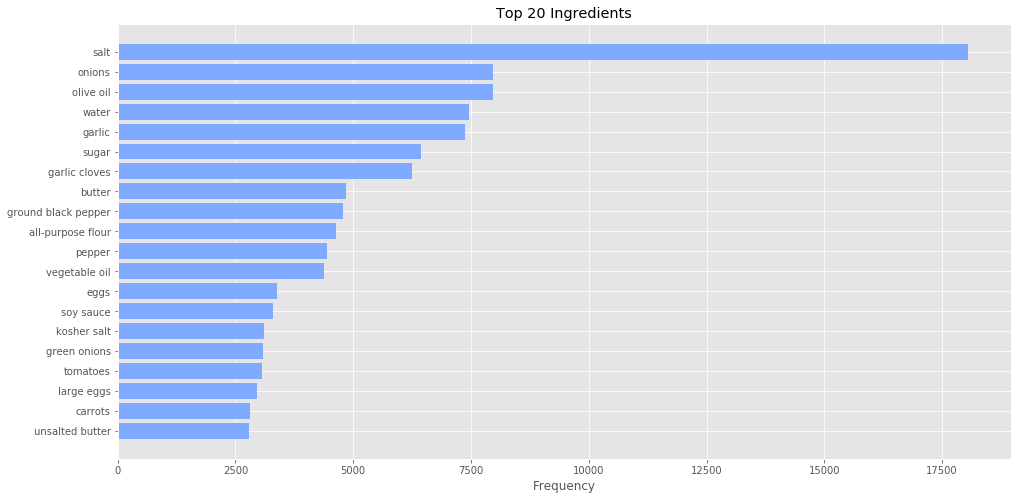

In [26]:
mostcommon = ingr_counts.most_common(20) # Returns list of tuples ('ingr', count)
mostcommoningr = [i[0] for i in mostcommon] # Retrieves ingredient in each tuple
mostcommoningr_counts = [i[1] for i in mostcommon] # Retrieves count in each tuple
mostcommoningr = list(reversed(mostcommoningr)) # Place most common at beginning of list
mostcommoningr_counts = list(reversed(mostcommoningr_counts))

plt.figure(figsize=(16,8))
plt.xlabel('Frequency')
plt.title('Top 20 Ingredients')
plt.barh(mostcommoningr, mostcommoningr_counts, color=COLOR)

Let's view the frequency of the ingredients as a wordcloud to see a little more than just the top 20.

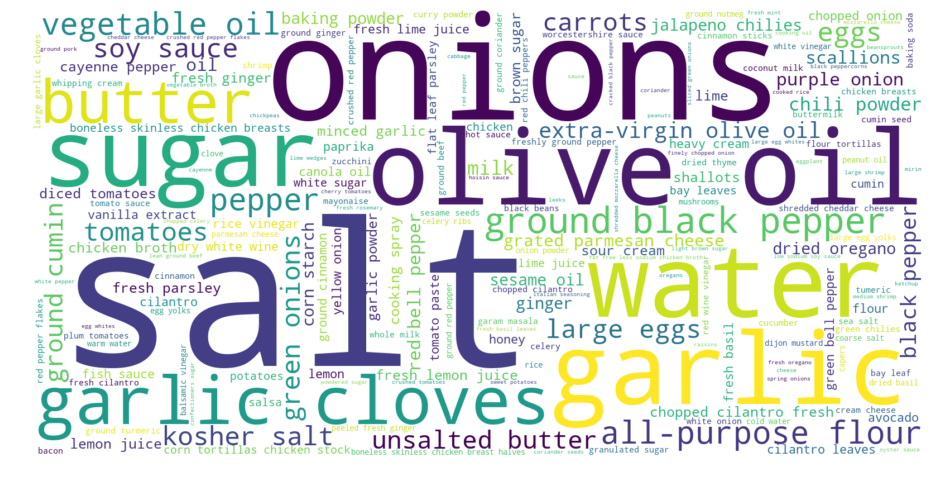

In [27]:
wordcloud = WordCloud(width=1600, height=800,random_state=21, background_color='white').generate_from_frequencies(ingr_counts)
plt.figure(figsize=(16, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In summary, the data looks fairly clean, the ingredients as we see from the above visualizations look normal.
For now, the only prepocessing we will apply is:
- converting to lower case.

In the future we will consider:
- lemmatization
- misspellings.

### Create the Model

In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_data['ingredients_text'].tolist(), train_data['cuisine'].tolist(), test_size=.2, random_state=20)
X_train[:5] # Print the first 5 items

['lime, mung beans, sesame oil, peanut butter, carrots, fish sauce, fresh ginger, green onions, cilantro, garlic cloves, monterey jack, honey, hoisin sauce, red pepper, pizza doughs, boiling water, soy sauce, sriracha, cooked chicken, rice vinegar, oyster sauce',
 'eggs, decorating sugars, softened butter, white sugar, ground cinnamon, milk, salt, confectioners sugar, melted butter, active dry yeast, all-purpose flour, sour cream, warm water, vanilla extract, chopped pecans',
 'olive oil, crushed red pepper, tomatoes, kalamata, dried oregano, sun-dried tomatoes, onions, capers, garlic',
 'butter, spinach leaves, salt, rainbow trout, heavy cream, fennel, freshly ground pepper',
 'chicken stock, veal, all-purpose flour, dried porcini mushrooms, large garlic cloves, onions, marsala wine, fresh thyme, ground allspice, dried thyme, button mushrooms']

In [29]:
from sklearn.feature_extraction.text import *
# from sklearn.preprocessing import LabelEncoder

vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [30]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

nb = MultinomialNB().fit(X_train, y_train)
logReg = LogisticRegression().fit(X_train, y_train)
#knn = KNeighborsClassifier(n_neighbors=5).fit(X_train, y_train)
tree = DecisionTreeClassifier().fit(X_train, y_train)
rf = RandomForestClassifier(n_estimators=5).fit(X_train, y_train)

c:\users\richard teller\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\richard teller\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [31]:
print("Naive Bayes: {}".format(nb.score(X_test, y_test)))
print("Logistic Regression: {}".format(logReg.score(X_test, y_test)))
#print("KNN with 10 neighbors: {}".format(knn.score(X_test, y_test)))
print("Decision Tree: {}".format(tree.score(X_test, y_test)))
print("Random Forest: {}".format(rf.score(X_test, y_test)))

Naive Bayes: 0.6681332495285983
Logistic Regression: 0.7748585795097424
Decision Tree: 0.6178504085480829
Random Forest: 0.6482715273412948
